In [34]:
import pandas as pd
import scanpy as sc
import numpy as np
from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100)

In [2]:
def pp(h5_path):
    adata = sc.read_10x_h5(h5_path)
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.25)
    sc.tl.umap(adata)
    return adata

In [3]:
ls

lung1.h5  lung2.h5  simple_scanpy_integration.ipynb  test.ipynb


In [27]:
lung1 = pp('lung1.h5')
lung2 = pp('lung2.h5')

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnDa

In [6]:
lung1

AnnData object with n_obs × n_vars = 11431 × 2741
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
lung2

AnnData object with n_obs × n_vars = 10023 × 2526
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

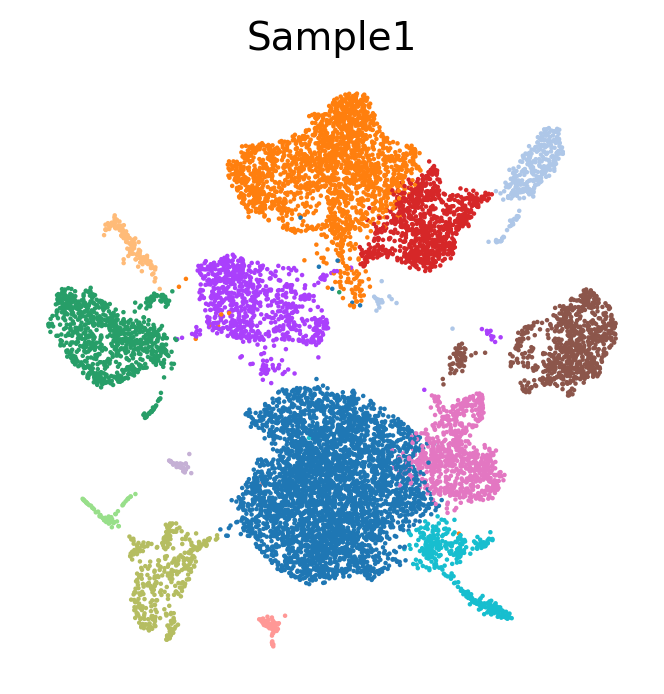

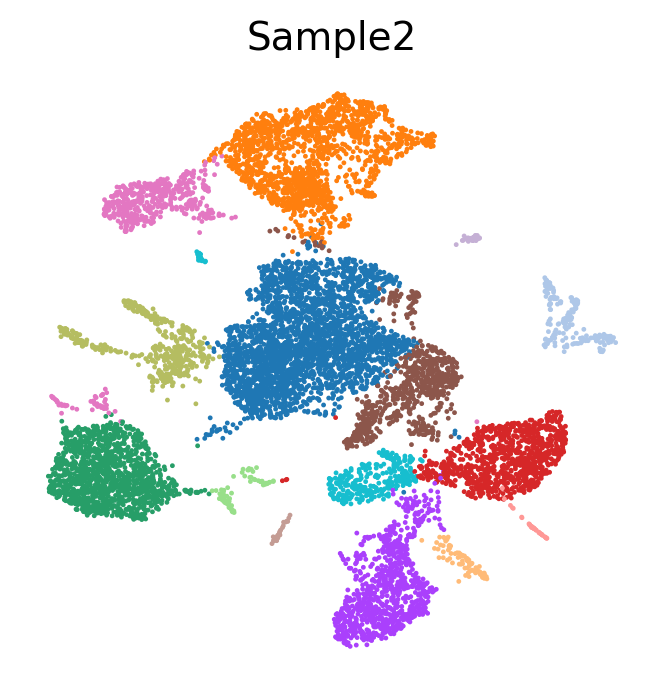

In [39]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(lung1, color = 'leiden', frameon = False, title = 'Sample1', legend_loc = None)
    sc.pl.umap(lung2, color = 'leiden', frameon = False, title = 'Sample2', legend_loc = None)

lung2 is used as the reference in this example. Use the sample that you suspect to have the greatest number of cell populations for the reference.This method is ideal for similar samples with corresponding cell populations.

In [40]:
lung1.obs['Sample'] = 'lung1'
lung2.obs['Sample'] = 'lung2'
#lung3.obs['Sample'] = 'lung3' #if more than 2 samples

In [41]:
var_names = lung2.var_names.intersection(lung1.var_names)
#var_names = var_names.intersection(lung3.var_names) #if more than 2 samples
lung2 = lung2[:, var_names]
lung1 = lung1[:, var_names]
#lung3 = lung3[:, var_names] #if more than 2 samples

In [45]:
sc.tl.ingest(lung1, lung2, obs= 'leiden')
#sc.tl.ingest(lung3, lung2, obs= 'leiden') #if more than 2 samples

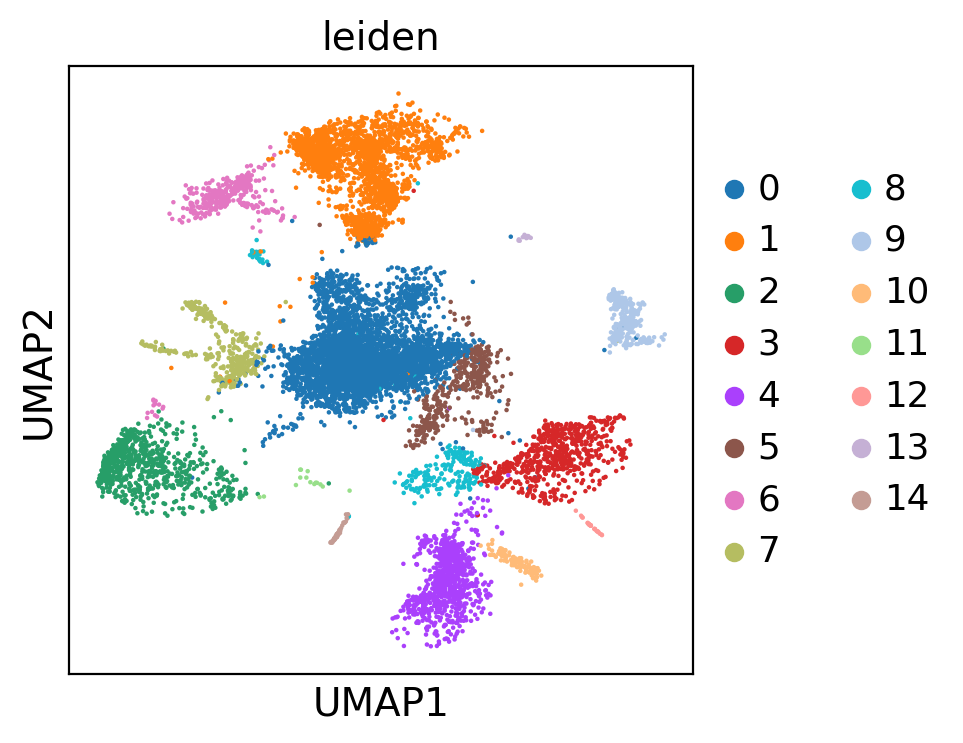

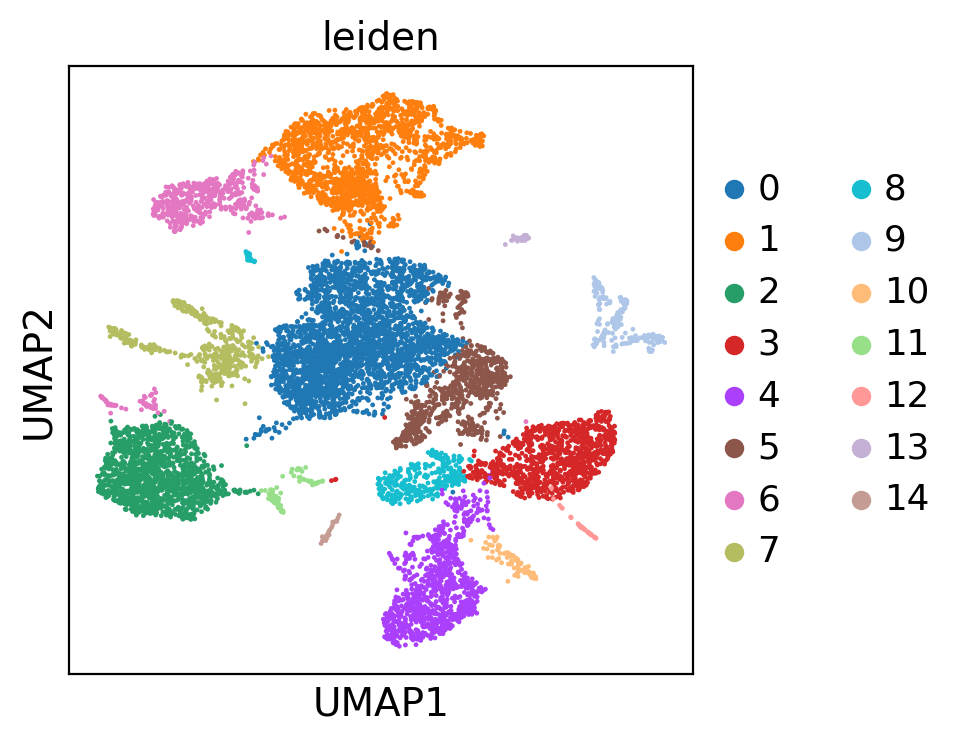

In [46]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(lung1, color = 'leiden')
    sc.pl.umap(lung2, color = 'leiden')

In [47]:
merged = lung2.concatenate(lung1)
#merged = merged.concatenate(lung3) #if more than 2 samples

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [16]:
merged

AnnData object with n_obs × n_vars = 21454 × 1938
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'highly_variable', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1'
    obsm: 'X_pca', 'X_umap'

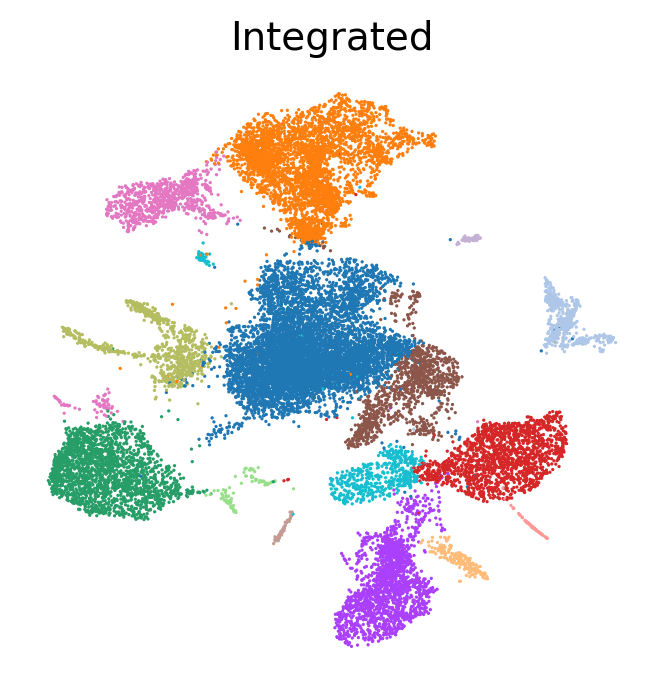

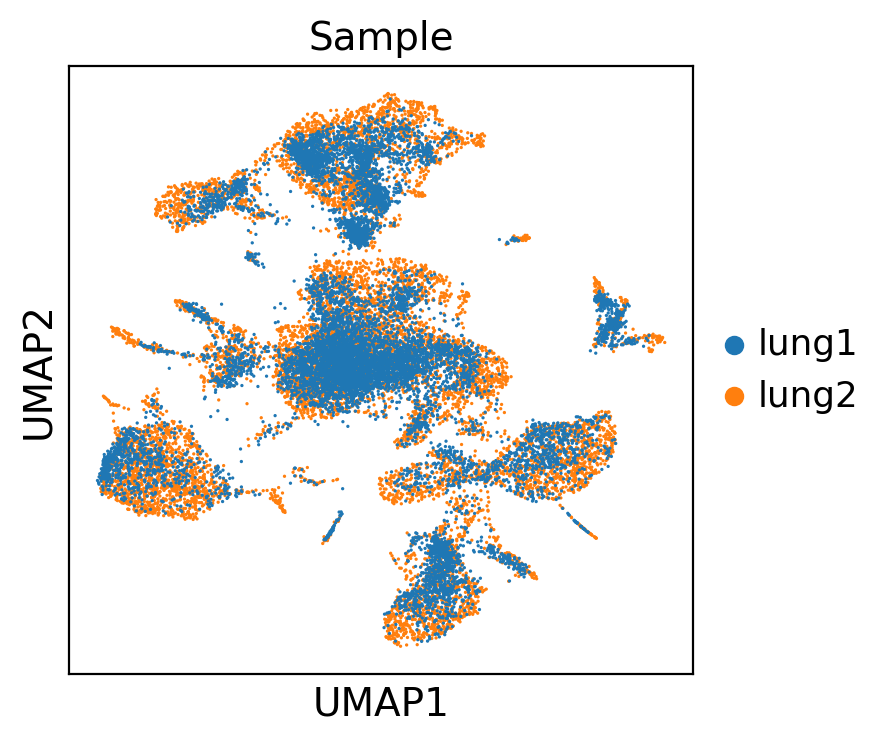

In [50]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(merged, color = 'leiden', frameon = False, title = 'Integrated', legend_loc = None)
    sc.pl.umap(merged, color = 'Sample')

In [22]:
counts = merged.obs.groupby(['Sample', 'leiden']).count().reset_index()

def map_per(x):
    samp, y = x
    tot = counts[counts.Sample == samp].total_counts.sum()
    return (y/tot)*100

counts['per'] = counts[['Sample', 'total_counts']].apply(map_per, axis = 1)

counts

,Sample,leiden,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,per
0,lung1,0,4639,4639,4639,4639,4639,4639,40.582626
1,lung1,1,2569,2569,2569,2569,2569,2569,22.473974
2,lung1,2,754,754,754,754,754,754,6.596098
3,lung1,3,653,653,653,653,653,653,5.712536
4,lung1,4,931,931,931,931,931,931,8.144519
5,lung1,5,402,402,402,402,402,402,3.516753
6,lung1,6,338,338,338,338,338,338,2.956872
7,lung1,7,372,372,372,372,372,372,3.254308
8,lung1,8,218,218,218,218,218,218,1.907095
9,lung1,9,350,350,350,350,350,350,3.061849


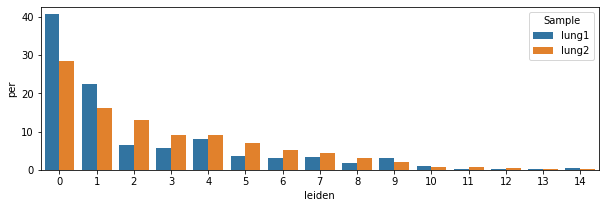

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,3))
ax = sns.barplot(x = 'leiden', y = 'per', hue = 'Sample', data = counts)